# Task 2: Real or Fake

In this task, we should determine that if an image is real or it is generated by AI.

In [ ]:
!git clone https://github.com/davda54/sam.git

Cloning into 'sam'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 200 (delta 85), reused 67 (delta 67), pack-reused 97
Receiving objects: 100% (200/200), 657.08 KiB | 11.14 MiB/s, done.
Resolving deltas: 100% (100/100), done.


**Import Libraries**

In [ ]:
import os
import torch
import random
from PIL import Image
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import one_hot
from torchvision import transforms
from torchvision.models import resnet152, mobilenet_v3_small
from torchsummary import summary
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
from sam.sam import SAM
from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Set Random Seeds and Parameters**

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

**Data and Saving Path**

In [ ]:
img_path = '/content/drive/MyDrive/ML-Data/ML Project Dataset - train'
label_path = '/content/drive/MyDrive/ML-Data/Train_Data.csv'
model_save_path = '/content/drive/MyDrive/ML-Data/task2_weights'

In [ ]:
train_df = pd.read_csv(label_path + 'train_dataset.csv')
val_df = pd.read_csv(label_path + 'val_dataset.csv')

Our dataset is approximately balanced in both train and test sets:

In [ ]:
train_df['Fake_cat'].value_counts()

real    1249
fake    1245
Name: Fake_label, dtype: int64

In [ ]:
val_df['Fake_cat'].value_counts()

fake    315
real    309
Name: Fake_label, dtype: int64

**Custome Dataset**


*   `root_dir`: The path to image directory
*   `annotation_file`: Tha path to .csv file containing labels
*   `label_column`: Determines classification task
* `transform`: The transformation we want to apply on images



In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, label_df, label_column, transform=None):
        self.root_dir = root_dir
        self.label_df = label_df
        self.transform = transform
        self.data = self.read_annotations(label_column)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

    def read_annotations(self, label_column):
        image_list = list(self.label_df['Image_name'])
        label_list = list(self.label_df[label_column])

        data = [(img, label) for img, label in zip(image_list, label_list)]

        return data

**From Scratch CNN Model**

Here is the class implementation of CNN model mentioned in project documentation. To create a CNNModel, we should determine `output_dim` in initialization:

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, output_dim):
        super(CNNModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)  # Output: (112, 112, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (56, 56, 64)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # Output: (56, 56, 64)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: (56, 56, 128)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Output: (56, 56, 128)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Output: (56, 56, 128)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.ReLU()

        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, stride=4, padding=1)  # Output: (14, 14, 256)
        self.bn6 = nn.BatchNorm2d(256)

        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)  # Output: (14, 14, 256)
        self.bn7 = nn.BatchNorm2d(256)
        self.relu7 = nn.ReLU()

        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # Output: (7, 7, 512)
        self.bn8 = nn.BatchNorm2d(512)
        self.relu8 = nn.ReLU()

        # Average pooling and fully connected layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Output: (1, 1, 512)
        self.fc = nn.Linear(512, output_dim)  # Output: (output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)

        x = self.conv6(x)
        x = self.bn6(x)

        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)

        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu8(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.softmax(x)
        return x


 **Customizing ResNet152 for Classification**

In [ ]:
class CustomResNet152Frozen(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet152Frozen, self).__init__()
        # Load the pre-trained ResNet-152 model with frozen weights
        resnet = resnet152(pretrained=True)

        # Freeze all layers except the classification layer
        for param in resnet.parameters():
            param.requires_grad = False

        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Linear(num_ftrs, num_classes)

        self.model = resnet

    def forward(self, x):
        x = self.model(x)
        return x

**Customizing MobileNetV3 for Classification**

In [ ]:
class CustomMobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(CustomMobileNetV3, self).__init__()
        # Load the pre-trained MobileNet-V3 model with frozen weights
        mobile = mobilenet_v3_small(pretrained=True)

        # Freeze all layers except the classification layer
        for param in mobile.parameters():
            param.requires_grad = False

        num_ftrs = mobile.classifier[-1].in_features
        mobile.classifier[-1] = nn.Linear(num_ftrs, num_classes)

        self.model = mobile


    def forward(self, x):
        x = self.model(x)
        return x

**function to plot learning curve**

We utilize the following function to plot model loss and accuracy in the training process on both train and validation datasets:

In [ ]:

def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, plot_title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(f'Learning Curves with {plot_title}')
    plt.show()


# Impact of Data Augmentation

**MixUp data augmentation method**

In [ ]:
def mixup_label(label, lam, num_classes):
        label = one_hot(label, num_classes=num_classes)
        if not label.dtype.is_floating_point:
            label = label.float()
        return label.roll(1, 0).mul_(1.0 - lam).add_(label.mul(lam))

In [ ]:
def mixup_data(inputs, labels, num_classes, alpha=1.0):
    """Applies mixup augmentation to a batch of inputs and integer labels.

    Args:
        inputs: A batch of input tensors (e.g., images or features).
        labels: A batch of integer labels.
        alpha: Hyperparameter for the Beta distribution used to sample mixing ratios.

    Returns:
        A tuple containing the mixed inputs and mixed labels.
    """

    lam = torch.distributions.Beta(torch.tensor([alpha]), torch.tensor([alpha])).sample()
    lam = lam.to(device)
    batch_size = labels.shape[0]

    # Mixup inputs
    mixed_inputs = lam * inputs + (1 - lam) * inputs.roll(1, 0)

    # Mixup labels (integer mixing)
    mixed_labels = mixup_label(labels, lam, num_classes)
    return mixed_inputs, mixed_labels

In [ ]:
def train_model_with_transforms(model, train_loader, val_loader, criterion, optimizer, scheduler, transform, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_labels_train = []
        all_predictions_train = []

        for inputs, labels  in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            if transform == 'mixup':
                mixup_inputs, mixup_labels = mixup_data(inputs, labels, num_classes=2)
                outputs = model(mixup_inputs)
                loss = criterion(outputs, mixup_labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            all_labels_train.extend(labels.cpu().numpy())
            all_predictions_train.extend(predicted_train.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        epoch_accuracy_train = correct_train / total_train
        train_accuracies.append(epoch_accuracy_train)

        # Calculate F1 score
        f1_train = f1_score(all_labels_train, all_predictions_train, average='weighted')

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        running_loss_val = 0.0
        all_labels_val = []
        all_predictions_val = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs_val = model(inputs)
                loss_val = criterion(outputs_val, labels)
                running_loss_val += loss_val.item()

                _, predicted_val = torch.max(outputs_val.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

                all_labels_val.extend(labels.cpu().numpy())
                all_predictions_val.extend(predicted_val.cpu().numpy())

        epoch_loss_val = running_loss_val / len(val_loader)
        val_losses.append(epoch_loss_val)
        epoch_accuracy_val = correct_val / total_val
        val_accuracies.append(epoch_accuracy_val)

        # Calculate F1 score
        f1_val = f1_score(all_labels_val, all_predictions_val, average='weighted')

        # Update learning rate
        scheduler.step()

        # Print and store results for analysis
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {epoch_loss:.3f} | Train Acc: {epoch_accuracy_train*100:.2f}% | Train F1: {f1_train*100:.2f}%')
        print(f'\t Val. Loss: {epoch_loss_val:.3f} |  Val. Acc: {epoch_accuracy_val*100:.2f}% | Val F1: {f1_val*100:.2f}%')


    # Save the model weights after training
    torch.save(model.state_dict(), f'{model_save_path}/{model._get_name()}_{transform}.pth')

    return train_losses, val_losses, train_accuracies, val_accuracies

## ResNet-152

In [ ]:
# Define different augmentation methods
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
random_rotation = transforms.RandomRotation(degrees=45)
random_crop = transforms.RandomCrop(size=(200, 200))
gaussian_blur = transforms.GaussianBlur(kernel_size=3)
grayscale = transforms.Grayscale(num_output_channels=3)
horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)
vertical_flip = transforms.RandomVerticalFlip(p=0.5)

Adam optimizer and StepLR scheduler are fixed for all of the experiments in this section:

Overall, based on the results you will see in the later parts, this task is more challenging than the first task: becuase our results are worse than the previous task:

Different method do not have many differences based on results (except for grayscale and mixup). But VerticalFlip showed better results on validation set:

### Without any Augmentation

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Fake_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Fake_label', transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.672 | Train Acc: 59.66% | Train F1: 59.65%
	 Val. Loss: 0.600 |  Val. Acc: 67.47% | Val F1: 66.04%
Epoch: 02
	Train Loss: 0.608 | Train Acc: 66.68% | Train F1: 66.68%
	 Val. Loss: 0.586 |  Val. Acc: 69.07% | Val F1: 67.76%
Epoch: 03
	Train Loss: 0.526 | Train Acc: 73.38% | Train F1: 73.37%
	 Val. Loss: 0.533 |  Val. Acc: 72.12% | Val F1: 71.77%
Epoch: 04
	Train Loss: 0.525 | Train Acc: 72.98% | Train F1: 72.97%
	 Val. Loss: 0.694 |  Val. Acc: 63.30% | Val F1: 58.93%
Epoch: 05
	Train Loss: 0.530 | Train Acc: 73.10% | Train F1: 73.07%
	 Val. Loss: 0.516 |  Val. Acc: 73.56% | Val F1: 73.43%
Epoch: 06
	Train Loss: 0.476 | Train Acc: 76.70% | Train F1: 76.70%
	 Val. Loss: 0.516 |  Val. Acc: 74.52% | Val F1: 74.50%
Epoch: 07
	Train Loss: 0.472 | Train Acc: 77.47% | Train F1: 77.46%
	 Val. Loss: 0.510 |  Val. Acc: 74.20% | Val F1: 74.12%
Epoch: 08
	Train Loss: 0.472 | Train Acc: 76.90% | Train F1: 76.90%
	 Val. Loss: 0.512 |  Val. Acc: 74.20% | Val F1: 74.10%
Epoch: 0

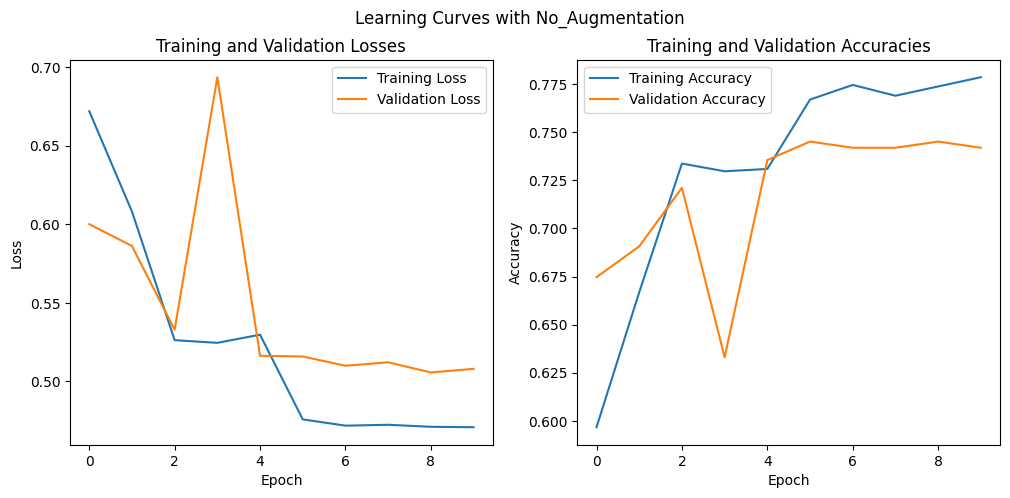

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "No_Augmentation",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "No_Augmentation")

### ColorJitter

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
base_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

transform = transforms.Compose([
        color_jitter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Fake_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Fake_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.661 | Train Acc: 60.95% | Train F1: 60.94%
	 Val. Loss: 0.589 |  Val. Acc: 70.19% | Val F1: 70.12%
Epoch: 02
	Train Loss: 0.621 | Train Acc: 65.96% | Train F1: 65.96%
	 Val. Loss: 0.633 |  Val. Acc: 64.10% | Val F1: 60.63%
Epoch: 03
	Train Loss: 0.569 | Train Acc: 69.73% | Train F1: 69.73%
	 Val. Loss: 0.559 |  Val. Acc: 69.07% | Val F1: 68.38%
Epoch: 04
	Train Loss: 0.553 | Train Acc: 72.09% | Train F1: 72.09%
	 Val. Loss: 0.548 |  Val. Acc: 70.67% | Val F1: 70.11%
Epoch: 05
	Train Loss: 0.533 | Train Acc: 72.98% | Train F1: 72.97%
	 Val. Loss: 0.552 |  Val. Acc: 72.12% | Val F1: 71.75%
Epoch: 06
	Train Loss: 0.499 | Train Acc: 75.90% | Train F1: 75.88%
	 Val. Loss: 0.533 |  Val. Acc: 72.44% | Val F1: 72.31%
Epoch: 07
	Train Loss: 0.509 | Train Acc: 74.70% | Train F1: 74.69%
	 Val. Loss: 0.527 |  Val. Acc: 72.60% | Val F1: 72.57%
Epoch: 08
	Train Loss: 0.511 | Train Acc: 75.46% | Train F1: 75.43%
	 Val. Loss: 0.527 |  Val. Acc: 74.04% | Val F1: 74.03%
Epoch: 0

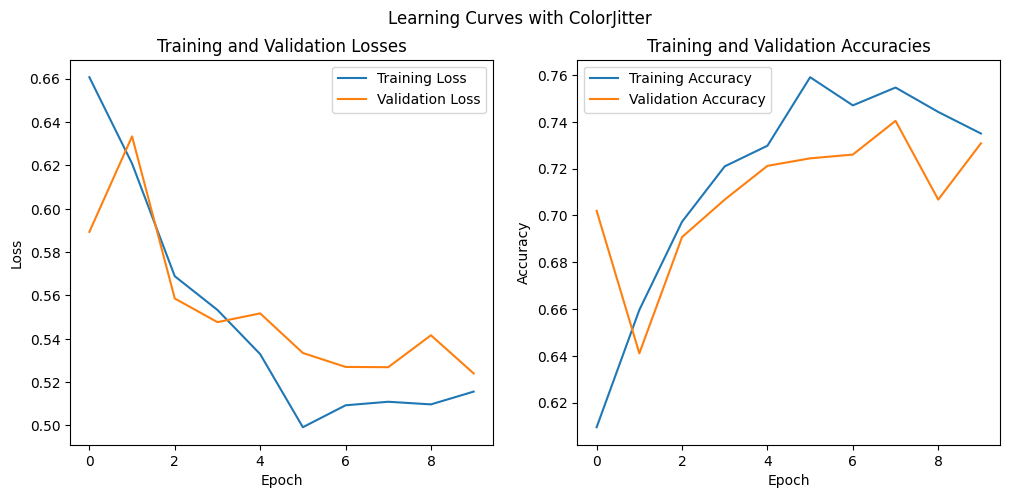

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "ColorJitter",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "ColorJitter")

### RandomRotation

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        random_rotation,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Fake_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Fake_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.678 | Train Acc: 59.26% | Train F1: 59.26%
	 Val. Loss: 0.598 |  Val. Acc: 68.59% | Val F1: 68.58%
Epoch: 02
	Train Loss: 0.617 | Train Acc: 65.36% | Train F1: 65.36%
	 Val. Loss: 0.597 |  Val. Acc: 65.22% | Val F1: 63.54%
Epoch: 03
	Train Loss: 0.584 | Train Acc: 69.41% | Train F1: 69.40%
	 Val. Loss: 0.566 |  Val. Acc: 69.55% | Val F1: 69.55%
Epoch: 04
	Train Loss: 0.575 | Train Acc: 68.00% | Train F1: 68.00%
	 Val. Loss: 0.624 |  Val. Acc: 66.35% | Val F1: 64.02%
Epoch: 05
	Train Loss: 0.582 | Train Acc: 69.33% | Train F1: 69.32%
	 Val. Loss: 0.558 |  Val. Acc: 71.47% | Val F1: 71.14%
Epoch: 06
	Train Loss: 0.531 | Train Acc: 73.94% | Train F1: 73.93%
	 Val. Loss: 0.550 |  Val. Acc: 70.51% | Val F1: 70.44%
Epoch: 07
	Train Loss: 0.528 | Train Acc: 73.94% | Train F1: 73.94%
	 Val. Loss: 0.552 |  Val. Acc: 72.44% | Val F1: 72.15%
Epoch: 08
	Train Loss: 0.538 | Train Acc: 72.09% | Train F1: 72.08%
	 Val. Loss: 0.544 |  Val. Acc: 72.60% | Val F1: 72.52%
Epoch: 0

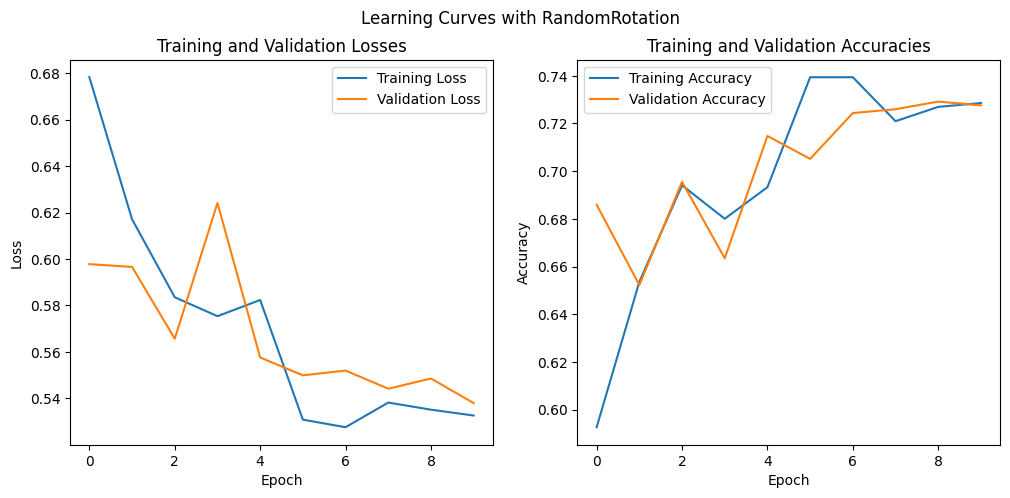

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "RandomRotation",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "RandomRotation")

### RandomCrop

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        random_crop,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Fake_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Fake_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.644 | Train Acc: 63.55% | Train F1: 63.54%
	 Val. Loss: 0.621 |  Val. Acc: 65.87% | Val F1: 63.34%
Epoch: 02
	Train Loss: 0.576 | Train Acc: 70.09% | Train F1: 70.08%
	 Val. Loss: 0.558 |  Val. Acc: 70.83% | Val F1: 70.81%
Epoch: 03
	Train Loss: 0.547 | Train Acc: 72.25% | Train F1: 72.24%
	 Val. Loss: 0.564 |  Val. Acc: 69.55% | Val F1: 69.15%
Epoch: 04
	Train Loss: 0.559 | Train Acc: 70.09% | Train F1: 70.08%
	 Val. Loss: 0.557 |  Val. Acc: 71.63% | Val F1: 71.37%
Epoch: 05
	Train Loss: 0.519 | Train Acc: 73.94% | Train F1: 73.93%
	 Val. Loss: 0.555 |  Val. Acc: 70.99% | Val F1: 70.87%
Epoch: 06
	Train Loss: 0.490 | Train Acc: 76.34% | Train F1: 76.34%
	 Val. Loss: 0.556 |  Val. Acc: 71.15% | Val F1: 71.05%
Epoch: 07
	Train Loss: 0.494 | Train Acc: 75.58% | Train F1: 75.58%
	 Val. Loss: 0.571 |  Val. Acc: 70.83% | Val F1: 70.43%
Epoch: 08
	Train Loss: 0.481 | Train Acc: 77.19% | Train F1: 77.18%
	 Val. Loss: 0.585 |  Val. Acc: 70.51% | Val F1: 69.75%
Epoch: 0

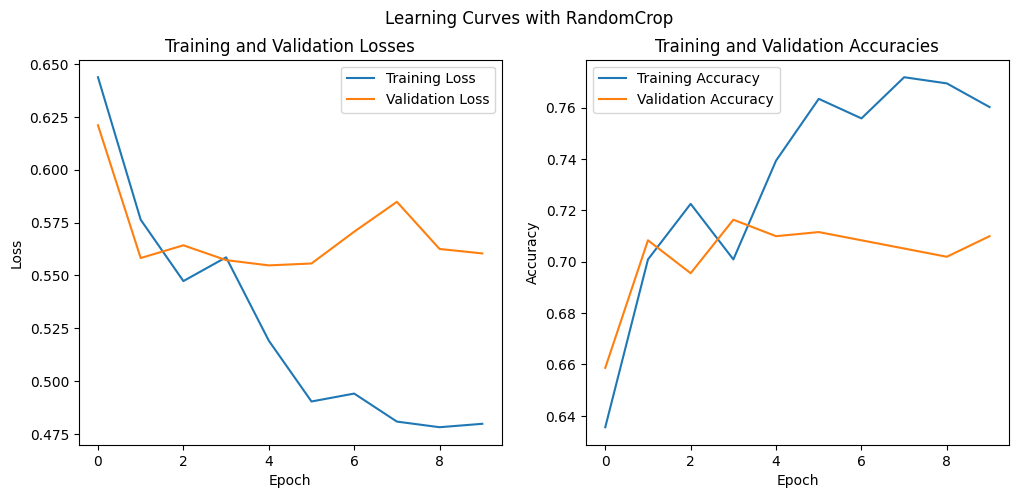

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "RandomCrop",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "RandomCrop")

### GaussianBlur

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        gaussian_blur,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Fake_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Fake_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Adjust total_steps as needed

Epoch: 01
	Train Loss: 0.639 | Train Acc: 63.23% | Train F1: 63.23%
	 Val. Loss: 0.598 |  Val. Acc: 64.26% | Val F1: 63.47%
Epoch: 02
	Train Loss: 0.565 | Train Acc: 70.73% | Train F1: 70.72%
	 Val. Loss: 0.573 |  Val. Acc: 69.07% | Val F1: 68.22%
Epoch: 03
	Train Loss: 0.523 | Train Acc: 73.90% | Train F1: 73.89%
	 Val. Loss: 0.554 |  Val. Acc: 71.79% | Val F1: 71.38%
Epoch: 04
	Train Loss: 0.543 | Train Acc: 71.89% | Train F1: 71.89%
	 Val. Loss: 0.558 |  Val. Acc: 70.99% | Val F1: 70.79%
Epoch: 05
	Train Loss: 0.544 | Train Acc: 71.85% | Train F1: 71.85%
	 Val. Loss: 0.541 |  Val. Acc: 72.76% | Val F1: 72.71%
Epoch: 06
	Train Loss: 0.482 | Train Acc: 76.66% | Train F1: 76.66%
	 Val. Loss: 0.541 |  Val. Acc: 71.15% | Val F1: 71.10%
Epoch: 07
	Train Loss: 0.482 | Train Acc: 75.62% | Train F1: 75.62%
	 Val. Loss: 0.540 |  Val. Acc: 72.44% | Val F1: 72.44%
Epoch: 08
	Train Loss: 0.481 | Train Acc: 77.11% | Train F1: 77.10%
	 Val. Loss: 0.538 |  Val. Acc: 72.44% | Val F1: 72.44%
Epoch: 0

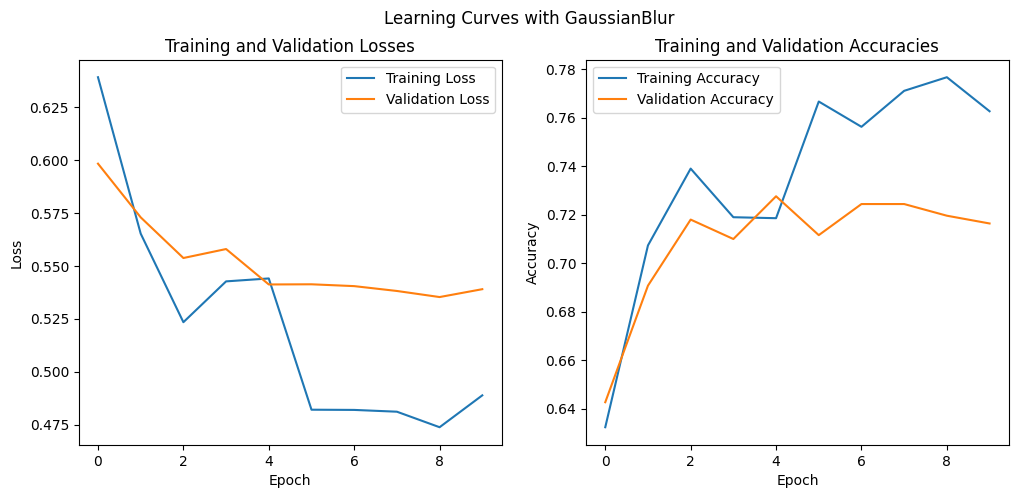

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "GaussianBlur",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "GaussianBlur")

### Grayscale

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        grayscale,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Fake_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Fake_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.645 | Train Acc: 63.07% | Train F1: 63.04%
	 Val. Loss: 0.708 |  Val. Acc: 56.73% | Val F1: 55.83%
Epoch: 02
	Train Loss: 0.573 | Train Acc: 69.65% | Train F1: 69.65%
	 Val. Loss: 0.956 |  Val. Acc: 52.88% | Val F1: 44.82%
Epoch: 03
	Train Loss: 0.545 | Train Acc: 71.37% | Train F1: 71.36%
	 Val. Loss: 0.998 |  Val. Acc: 52.08% | Val F1: 50.66%
Epoch: 04
	Train Loss: 0.534 | Train Acc: 73.06% | Train F1: 73.05%
	 Val. Loss: 0.911 |  Val. Acc: 54.01% | Val F1: 52.99%
Epoch: 05
	Train Loss: 0.506 | Train Acc: 74.62% | Train F1: 74.61%
	 Val. Loss: 1.070 |  Val. Acc: 52.88% | Val F1: 51.29%
Epoch: 06
	Train Loss: 0.480 | Train Acc: 77.11% | Train F1: 77.10%
	 Val. Loss: 0.940 |  Val. Acc: 54.49% | Val F1: 52.71%
Epoch: 07
	Train Loss: 0.476 | Train Acc: 76.70% | Train F1: 76.68%
	 Val. Loss: 1.005 |  Val. Acc: 51.76% | Val F1: 51.68%
Epoch: 08
	Train Loss: 0.475 | Train Acc: 77.51% | Train F1: 77.50%
	 Val. Loss: 0.966 |  Val. Acc: 50.96% | Val F1: 50.94%
Epoch: 0

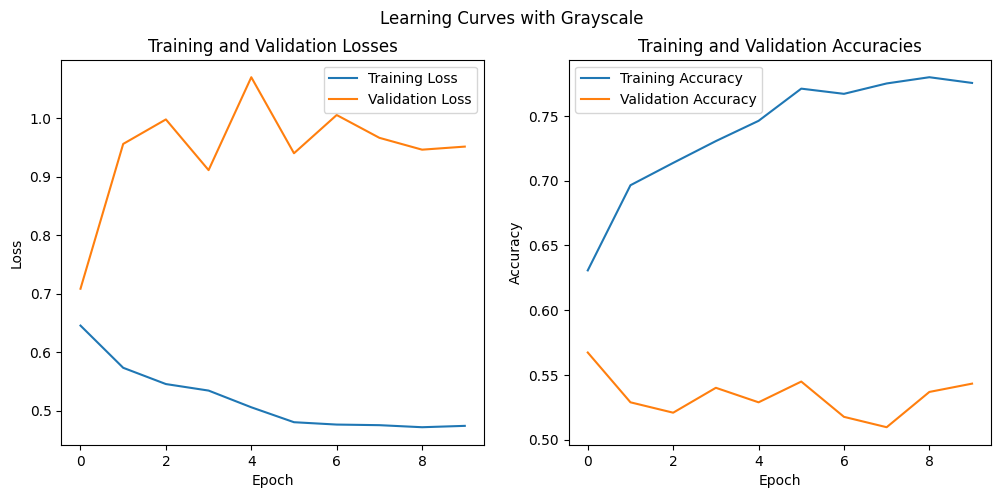

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "Grayscale",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "Grayscale")

### RandomVerticalFlip

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        vertical_flip,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Fake_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Fake_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Adjust total_steps as needed

Epoch: 01
	Train Loss: 0.641 | Train Acc: 62.55% | Train F1: 62.55%
	 Val. Loss: 0.620 |  Val. Acc: 66.67% | Val F1: 64.54%
Epoch: 02
	Train Loss: 0.593 | Train Acc: 68.08% | Train F1: 68.08%
	 Val. Loss: 0.671 |  Val. Acc: 63.30% | Val F1: 59.02%
Epoch: 03
	Train Loss: 0.561 | Train Acc: 71.05% | Train F1: 71.04%
	 Val. Loss: 0.547 |  Val. Acc: 71.47% | Val F1: 70.96%
Epoch: 04
	Train Loss: 0.540 | Train Acc: 72.45% | Train F1: 72.44%
	 Val. Loss: 0.530 |  Val. Acc: 73.24% | Val F1: 73.00%
Epoch: 05
	Train Loss: 0.522 | Train Acc: 73.90% | Train F1: 73.90%
	 Val. Loss: 0.516 |  Val. Acc: 75.16% | Val F1: 75.15%
Epoch: 06
	Train Loss: 0.492 | Train Acc: 76.54% | Train F1: 76.54%
	 Val. Loss: 0.520 |  Val. Acc: 75.48% | Val F1: 75.47%
Epoch: 07
	Train Loss: 0.486 | Train Acc: 77.23% | Train F1: 77.22%
	 Val. Loss: 0.518 |  Val. Acc: 75.16% | Val F1: 75.16%
Epoch: 08
	Train Loss: 0.487 | Train Acc: 77.02% | Train F1: 77.02%
	 Val. Loss: 0.516 |  Val. Acc: 75.00% | Val F1: 74.90%
Epoch: 0

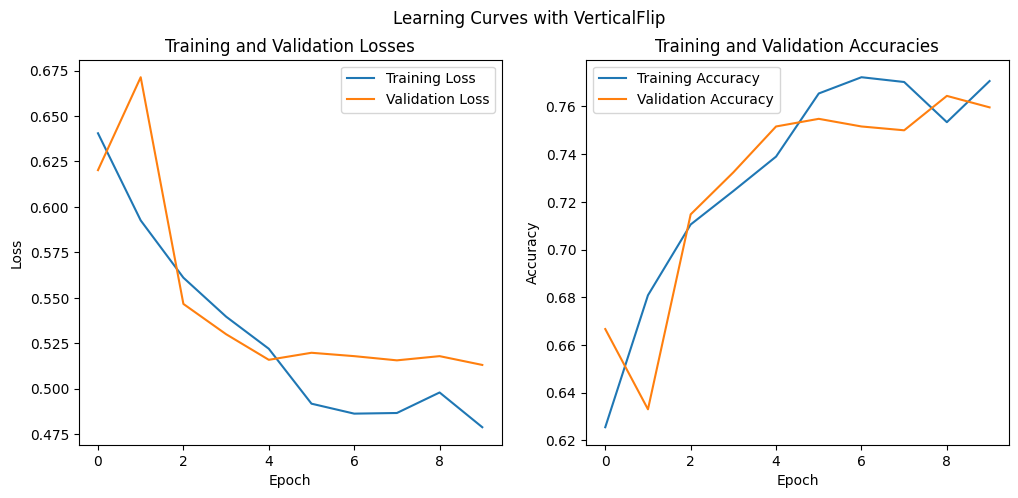

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "VerticalFlip",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "VerticalFlip")

### MixUp

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Fake_label', transform=base_transform)
val_dataset = CustomDataset(img_path, val_df, 'Fake_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.667 | Train Acc: 56.13% | Train F1: 56.12%
	 Val. Loss: 0.664 |  Val. Acc: 59.13% | Val F1: 52.15%
Epoch: 02
	Train Loss: 0.648 | Train Acc: 58.66% | Train F1: 58.66%
	 Val. Loss: 0.586 |  Val. Acc: 69.07% | Val F1: 68.90%
Epoch: 03
	Train Loss: 0.641 | Train Acc: 62.19% | Train F1: 62.16%
	 Val. Loss: 0.587 |  Val. Acc: 68.27% | Val F1: 67.12%
Epoch: 04
	Train Loss: 0.658 | Train Acc: 57.94% | Train F1: 57.94%
	 Val. Loss: 0.545 |  Val. Acc: 71.63% | Val F1: 71.59%
Epoch: 05
	Train Loss: 0.618 | Train Acc: 62.71% | Train F1: 62.69%
	 Val. Loss: 0.546 |  Val. Acc: 72.76% | Val F1: 72.76%
Epoch: 06
	Train Loss: 0.594 | Train Acc: 63.99% | Train F1: 63.99%
	 Val. Loss: 0.544 |  Val. Acc: 72.92% | Val F1: 72.92%
Epoch: 07
	Train Loss: 0.604 | Train Acc: 63.11% | Train F1: 63.08%
	 Val. Loss: 0.555 |  Val. Acc: 69.87% | Val F1: 69.27%
Epoch: 08
	Train Loss: 0.591 | Train Acc: 65.00% | Train F1: 64.95%
	 Val. Loss: 0.544 |  Val. Acc: 72.76% | Val F1: 72.61%
Epoch: 0

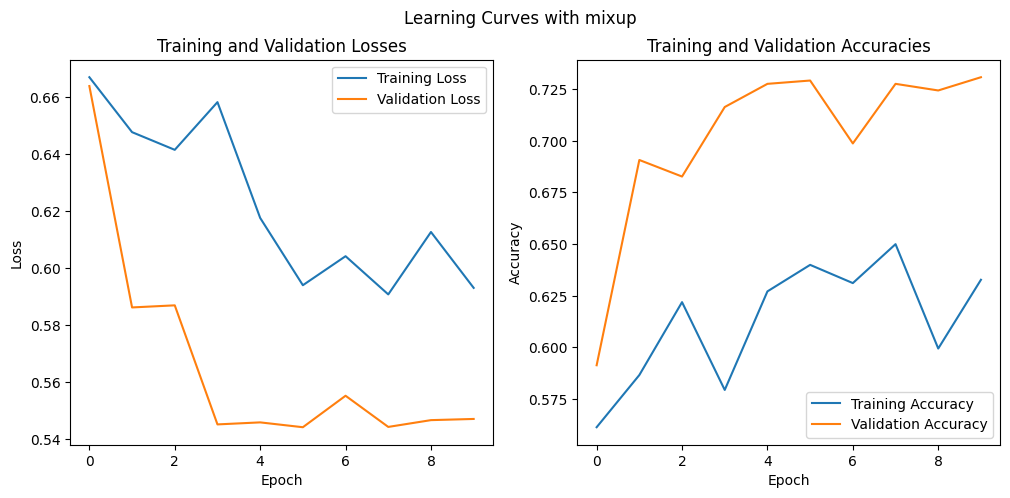

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "mixup",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "mixup")

## MobileNet-V3

For MobileNet, we just did experiment for ColorJitter. The results is approximately similar to ResNet:

### ColorJitter

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(2)
model.to(device)
clear_output()

In [ ]:
base_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

transform = transforms.Compose([
        color_jitter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Fake_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Fake_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.628 | Train Acc: 63.99% | Train F1: 63.99%
	 Val. Loss: 0.610 |  Val. Acc: 68.91% | Val F1: 68.14%
Epoch: 02
	Train Loss: 0.551 | Train Acc: 72.05% | Train F1: 72.05%
	 Val. Loss: 0.565 |  Val. Acc: 70.83% | Val F1: 70.76%
Epoch: 03
	Train Loss: 0.545 | Train Acc: 71.37% | Train F1: 71.35%
	 Val. Loss: 0.561 |  Val. Acc: 69.55% | Val F1: 69.55%
Epoch: 04
	Train Loss: 0.530 | Train Acc: 73.54% | Train F1: 73.53%
	 Val. Loss: 0.561 |  Val. Acc: 69.07% | Val F1: 69.07%
Epoch: 05
	Train Loss: 0.517 | Train Acc: 74.82% | Train F1: 74.81%
	 Val. Loss: 0.566 |  Val. Acc: 69.71% | Val F1: 69.70%
Epoch: 06
	Train Loss: 0.503 | Train Acc: 74.58% | Train F1: 74.57%
	 Val. Loss: 0.562 |  Val. Acc: 70.67% | Val F1: 70.65%
Epoch: 07
	Train Loss: 0.506 | Train Acc: 75.14% | Train F1: 75.12%
	 Val. Loss: 0.559 |  Val. Acc: 70.83% | Val F1: 70.82%
Epoch: 08
	Train Loss: 0.498 | Train Acc: 75.22% | Train F1: 75.20%
	 Val. Loss: 0.558 |  Val. Acc: 71.15% | Val F1: 71.15%
Epoch: 0

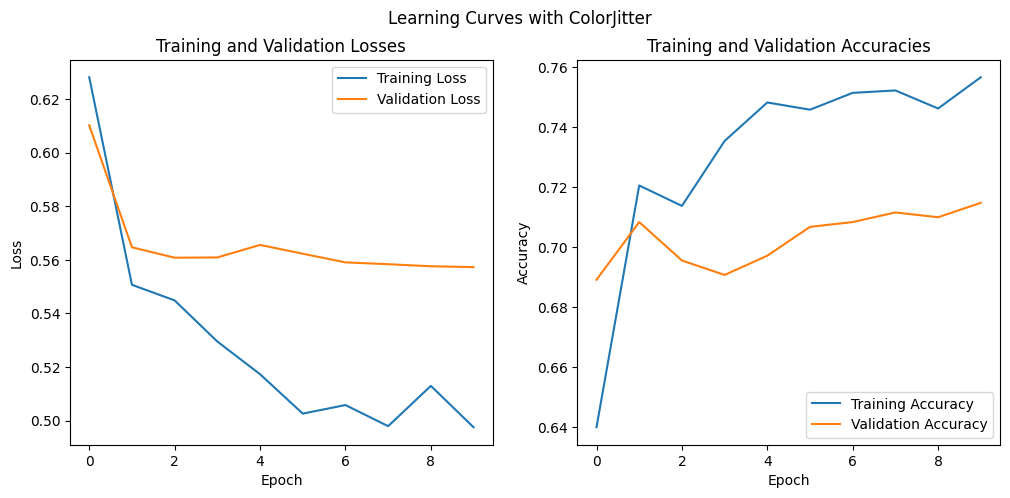

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "ColorJitter",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "ColorJitter")

## Custom CNN

The performance of CNN Model is worse than ResNet and MobileNet. It seems that this model is not suitable enough for this task:

### ColorJitter

In [ ]:
# Instantiate the model
model = CNNModel(2)
model.to(device)
clear_output()

In [ ]:
base_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

transform = transforms.Compose([
        color_jitter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Fake_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Fake_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.721 | Train Acc: 51.80% | Train F1: 51.56%
	 Val. Loss: 0.708 |  Val. Acc: 51.44% | Val F1: 41.85%
Epoch: 02
	Train Loss: 0.683 | Train Acc: 56.34% | Train F1: 56.33%
	 Val. Loss: 0.666 |  Val. Acc: 58.97% | Val F1: 58.95%
Epoch: 03
	Train Loss: 0.676 | Train Acc: 57.10% | Train F1: 57.05%
	 Val. Loss: 0.646 |  Val. Acc: 62.34% | Val F1: 62.17%
Epoch: 04
	Train Loss: 0.686 | Train Acc: 56.54% | Train F1: 56.50%
	 Val. Loss: 0.671 |  Val. Acc: 58.49% | Val F1: 56.42%
Epoch: 05
	Train Loss: 0.672 | Train Acc: 58.10% | Train F1: 58.09%
	 Val. Loss: 0.660 |  Val. Acc: 60.90% | Val F1: 60.29%
Epoch: 06
	Train Loss: 0.657 | Train Acc: 61.55% | Train F1: 61.44%
	 Val. Loss: 0.634 |  Val. Acc: 65.22% | Val F1: 65.16%
Epoch: 07
	Train Loss: 0.646 | Train Acc: 64.03% | Train F1: 64.03%
	 Val. Loss: 0.627 |  Val. Acc: 66.35% | Val F1: 66.26%
Epoch: 08
	Train Loss: 0.645 | Train Acc: 62.63% | Train F1: 62.58%
	 Val. Loss: 0.623 |  Val. Acc: 65.71% | Val F1: 65.51%
Epoch: 0

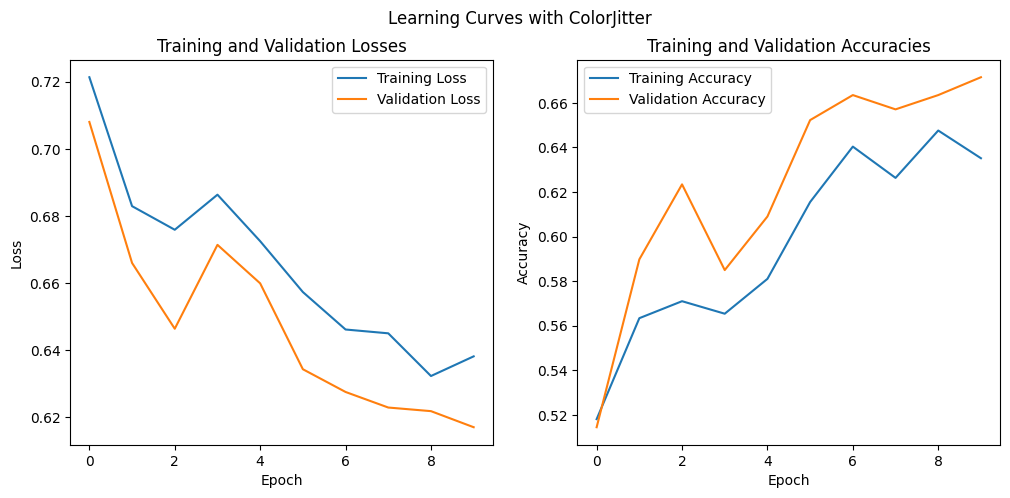

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "ColorJitter",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "ColorJitter")

# Optimization Algorithm

In [ ]:
def train_model_with_optimizer(model, train_loader, val_loader, criterion, optimizer, scheduler, transform=None, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    opt_name = optimizer.__class__.__name__

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_labels_train = []
        all_predictions_train = []

        for inputs, labels  in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            if transform == 'mixup':
                mixup_inputs, mixup_labels = mixup_data(inputs, labels, num_classes=2)
                outputs = model(mixup_inputs)
                loss = criterion(outputs, mixup_labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            if opt_name == 'SAM':
                # SAM needs two steps
                # first forward-backward pass
                optimizer.first_step(zero_grad=True)

                # second forward-backward pass
                criterion(model(inputs), labels).backward()  # make sure to do a full forward pass
                optimizer.second_step(zero_grad=True)
            else:
                optimizer.step()

            running_loss += loss.item()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            all_labels_train.extend(labels.cpu().numpy())
            all_predictions_train.extend(predicted_train.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        epoch_accuracy_train = correct_train / total_train
        train_accuracies.append(epoch_accuracy_train)

        # Calculate F1 score
        f1_train = f1_score(all_labels_train, all_predictions_train, average='weighted')

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        running_loss_val = 0.0
        all_labels_val = []
        all_predictions_val = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs_val = model(inputs)
                loss_val = criterion(outputs_val, labels)
                running_loss_val += loss_val.item()

                _, predicted_val = torch.max(outputs_val.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

                all_labels_val.extend(labels.cpu().numpy())
                all_predictions_val.extend(predicted_val.cpu().numpy())

        epoch_loss_val = running_loss_val / len(val_loader)
        val_losses.append(epoch_loss_val)
        epoch_accuracy_val = correct_val / total_val
        val_accuracies.append(epoch_accuracy_val)

        # Calculate F1 score
        f1_val = f1_score(all_labels_val, all_predictions_val, average='weighted')

        # Update learning rate
        scheduler.step()

        # Print and store results for analysis
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {epoch_loss:.3f} | Train Acc: {epoch_accuracy_train*100:.2f}% | Train F1: {f1_train*100:.2f}%')
        print(f'\t Val. Loss: {epoch_loss_val:.3f} |  Val. Acc: {epoch_accuracy_val*100:.2f}% | Val F1: {f1_val*100:.2f}%')


    # Save the model weights after training
    torch.save(model.state_dict(), f'{model_save_path}/{model._get_name()}_{optimizer.__class__.__name__}.pth')

    return train_losses, val_losses, train_accuracies, val_accuracies

## ResNet-152

ColorJitter as based transform and StepLR as scheduler:

In [ ]:
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)

base_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

transform = transforms.Compose([
        color_jitter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Fake_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Fake_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

SAM showed better performance in comparison with other methods on validation set:

### Stochastic Gradient Descent (SGD)

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Too many ups and downs!

Epoch: 01
	Train Loss: 12.607 | Train Acc: 57.54% | Train F1: 57.54%
	 Val. Loss: 5.852 |  Val. Acc: 67.15% | Val F1: 66.06%
Epoch: 02
	Train Loss: 5.568 | Train Acc: 66.84% | Train F1: 66.84%
	 Val. Loss: 2.975 |  Val. Acc: 72.12% | Val F1: 72.10%
Epoch: 03
	Train Loss: 6.783 | Train Acc: 65.12% | Train F1: 65.12%
	 Val. Loss: 7.727 |  Val. Acc: 63.30% | Val F1: 58.99%
Epoch: 04
	Train Loss: 5.365 | Train Acc: 67.96% | Train F1: 67.96%
	 Val. Loss: 3.958 |  Val. Acc: 71.79% | Val F1: 71.61%
Epoch: 05
	Train Loss: 11.033 | Train Acc: 65.96% | Train F1: 65.96%
	 Val. Loss: 5.543 |  Val. Acc: 70.03% | Val F1: 69.99%
Epoch: 06
	Train Loss: 4.449 | Train Acc: 75.18% | Train F1: 75.18%
	 Val. Loss: 4.374 |  Val. Acc: 73.56% | Val F1: 73.47%
Epoch: 07
	Train Loss: 3.293 | Train Acc: 77.79% | Train F1: 77.79%
	 Val. Loss: 3.608 |  Val. Acc: 73.56% | Val F1: 73.54%
Epoch: 08
	Train Loss: 2.742 | Train Acc: 77.91% | Train F1: 77.91%
	 Val. Loss: 3.159 |  Val. Acc: 74.68% | Val F1: 74.67%
Epoch:

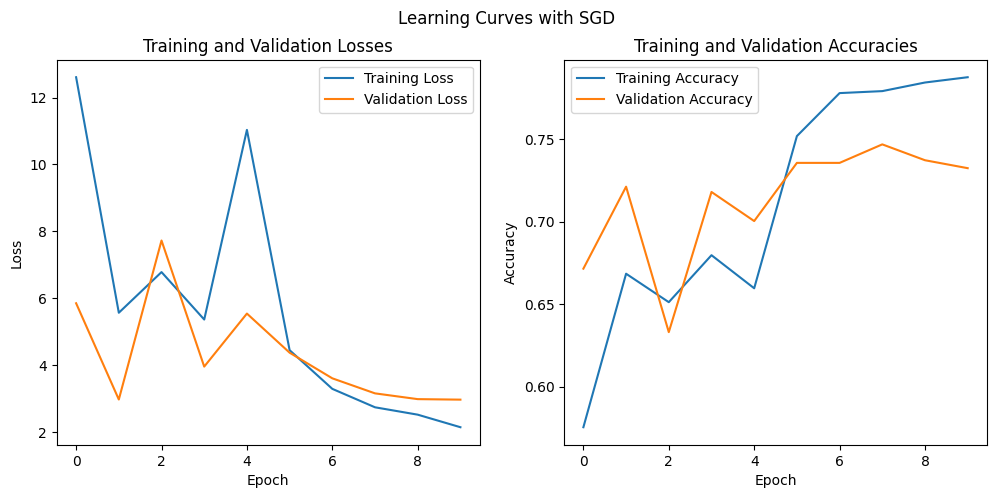

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "SGD")

### Adam

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

more stable results but not better than on validation!

Epoch: 01
	Train Loss: 0.651 | Train Acc: 62.47% | Train F1: 62.41%
	 Val. Loss: 0.589 |  Val. Acc: 67.31% | Val F1: 66.72%
Epoch: 02
	Train Loss: 0.580 | Train Acc: 68.97% | Train F1: 68.96%
	 Val. Loss: 0.579 |  Val. Acc: 66.99% | Val F1: 65.65%
Epoch: 03
	Train Loss: 0.570 | Train Acc: 68.85% | Train F1: 68.84%
	 Val. Loss: 0.540 |  Val. Acc: 72.12% | Val F1: 71.97%
Epoch: 04
	Train Loss: 0.573 | Train Acc: 70.33% | Train F1: 70.33%
	 Val. Loss: 0.531 |  Val. Acc: 73.24% | Val F1: 73.12%
Epoch: 05
	Train Loss: 0.529 | Train Acc: 73.18% | Train F1: 73.17%
	 Val. Loss: 0.569 |  Val. Acc: 69.71% | Val F1: 68.67%
Epoch: 06
	Train Loss: 0.497 | Train Acc: 76.18% | Train F1: 76.18%
	 Val. Loss: 0.526 |  Val. Acc: 72.92% | Val F1: 72.91%
Epoch: 07
	Train Loss: 0.505 | Train Acc: 75.94% | Train F1: 75.93%
	 Val. Loss: 0.536 |  Val. Acc: 70.99% | Val F1: 70.82%
Epoch: 08
	Train Loss: 0.507 | Train Acc: 74.62% | Train F1: 74.62%
	 Val. Loss: 0.538 |  Val. Acc: 71.47% | Val F1: 71.22%
Epoch: 0

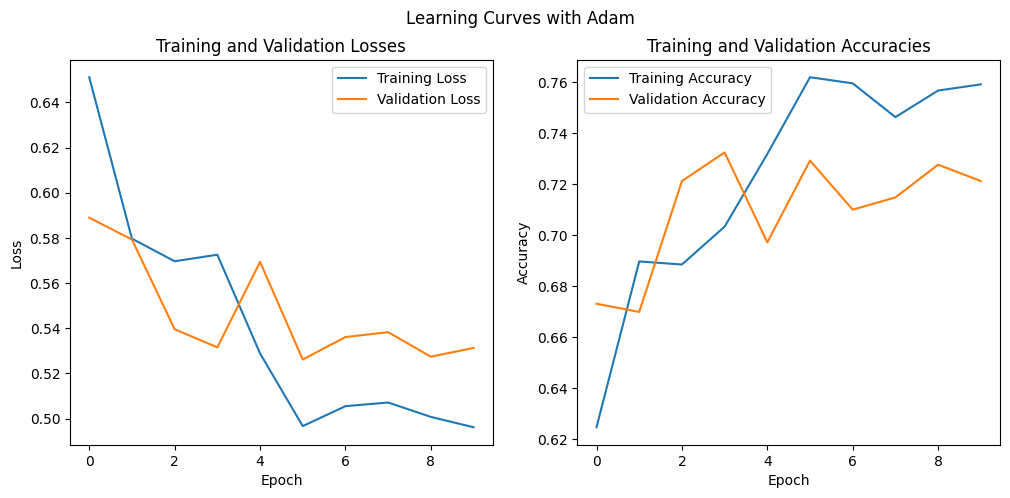

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "Adam")

### AdamW

Like Adam!

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.673 | Train Acc: 59.82% | Train F1: 59.82%
	 Val. Loss: 0.600 |  Val. Acc: 66.19% | Val F1: 65.40%
Epoch: 02
	Train Loss: 0.574 | Train Acc: 70.29% | Train F1: 70.26%
	 Val. Loss: 0.562 |  Val. Acc: 69.39% | Val F1: 69.09%
Epoch: 03
	Train Loss: 0.598 | Train Acc: 67.16% | Train F1: 67.15%
	 Val. Loss: 0.548 |  Val. Acc: 70.67% | Val F1: 70.25%
Epoch: 04
	Train Loss: 0.577 | Train Acc: 69.61% | Train F1: 69.61%
	 Val. Loss: 0.523 |  Val. Acc: 72.76% | Val F1: 72.75%
Epoch: 05
	Train Loss: 0.529 | Train Acc: 73.70% | Train F1: 73.70%
	 Val. Loss: 0.536 |  Val. Acc: 72.44% | Val F1: 72.17%
Epoch: 06
	Train Loss: 0.514 | Train Acc: 73.58% | Train F1: 73.57%
	 Val. Loss: 0.525 |  Val. Acc: 72.28% | Val F1: 72.17%
Epoch: 07
	Train Loss: 0.508 | Train Acc: 75.02% | Train F1: 75.02%
	 Val. Loss: 0.529 |  Val. Acc: 72.60% | Val F1: 72.49%
Epoch: 08
	Train Loss: 0.500 | Train Acc: 76.54% | Train F1: 76.53%
	 Val. Loss: 0.523 |  Val. Acc: 73.24% | Val F1: 73.22%
Epoch: 0

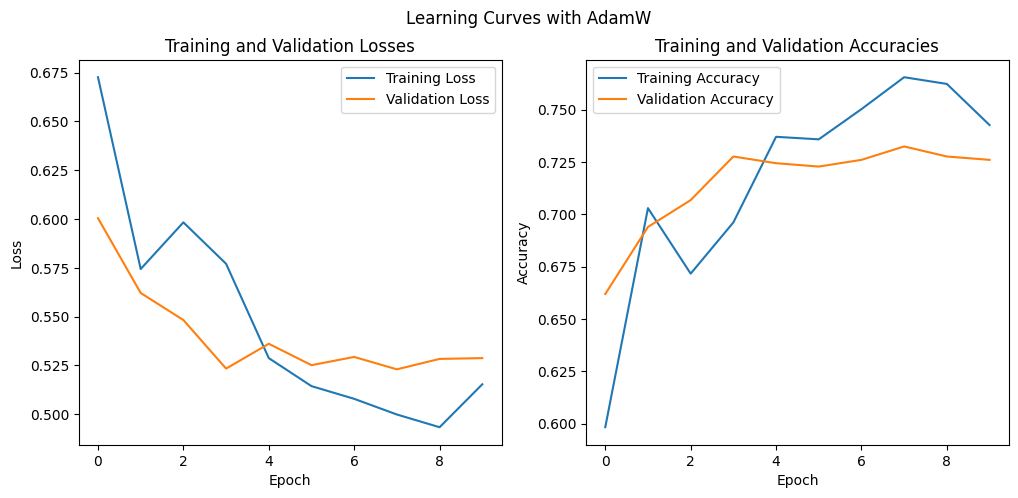

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "AdamW")

### RMSprop

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 1.062 | Train Acc: 56.70% | Train F1: 56.70%
	 Val. Loss: 0.663 |  Val. Acc: 63.46% | Val F1: 58.86%
Epoch: 02
	Train Loss: 0.646 | Train Acc: 65.64% | Train F1: 65.63%
	 Val. Loss: 0.555 |  Val. Acc: 71.47% | Val F1: 71.35%
Epoch: 03
	Train Loss: 0.655 | Train Acc: 65.40% | Train F1: 65.39%
	 Val. Loss: 0.561 |  Val. Acc: 70.03% | Val F1: 69.40%
Epoch: 04
	Train Loss: 0.641 | Train Acc: 65.08% | Train F1: 65.07%
	 Val. Loss: 0.559 |  Val. Acc: 69.55% | Val F1: 69.06%
Epoch: 05
	Train Loss: 0.578 | Train Acc: 69.49% | Train F1: 69.49%
	 Val. Loss: 0.541 |  Val. Acc: 72.12% | Val F1: 71.81%
Epoch: 06
	Train Loss: 0.514 | Train Acc: 74.70% | Train F1: 74.68%
	 Val. Loss: 0.534 |  Val. Acc: 71.63% | Val F1: 71.49%
Epoch: 07
	Train Loss: 0.514 | Train Acc: 74.38% | Train F1: 74.37%
	 Val. Loss: 0.537 |  Val. Acc: 72.44% | Val F1: 72.17%
Epoch: 08
	Train Loss: 0.504 | Train Acc: 75.26% | Train F1: 75.24%
	 Val. Loss: 0.527 |  Val. Acc: 72.44% | Val F1: 72.42%
Epoch: 0

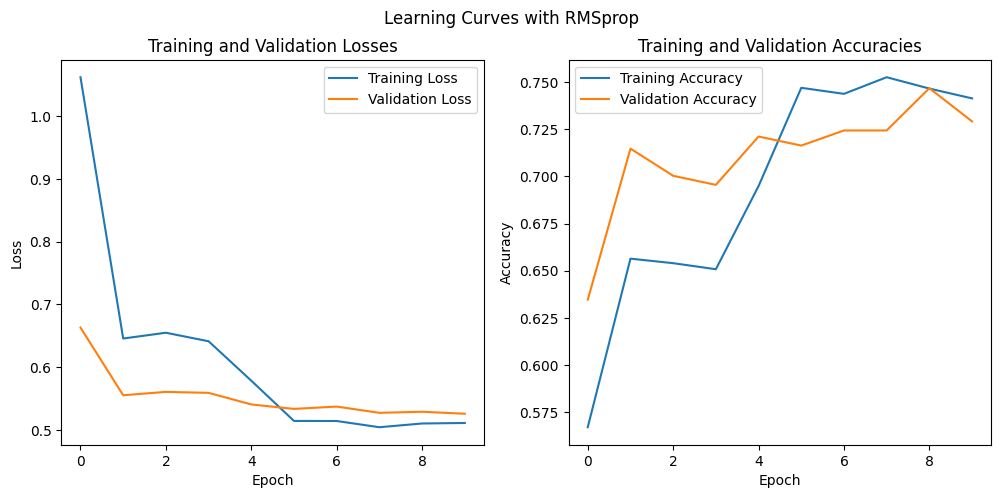

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "RMSprop")

### Sharpness-Aware Minimization (SAM)

Best on validation!

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, lr=0.1, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 01
	Train Loss: 12.039 | Train Acc: 59.62% | Train F1: 59.62%
	 Val. Loss: 3.819 |  Val. Acc: 70.35% | Val F1: 70.24%
Epoch: 02
	Train Loss: 7.546 | Train Acc: 66.56% | Train F1: 66.56%
	 Val. Loss: 6.131 |  Val. Acc: 65.22% | Val F1: 62.57%
Epoch: 03
	Train Loss: 6.627 | Train Acc: 66.88% | Train F1: 66.88%
	 Val. Loss: 3.907 |  Val. Acc: 71.15% | Val F1: 70.82%
Epoch: 04
	Train Loss: 4.882 | Train Acc: 70.37% | Train F1: 70.37%
	 Val. Loss: 4.506 |  Val. Acc: 69.39% | Val F1: 68.83%
Epoch: 05
	Train Loss: 7.717 | Train Acc: 66.44% | Train F1: 66.44%
	 Val. Loss: 13.545 |  Val. Acc: 61.70% | Val F1: 55.46%
Epoch: 06
	Train Loss: 4.116 | Train Acc: 75.18% | Train F1: 75.18%
	 Val. Loss: 3.194 |  Val. Acc: 74.36% | Val F1: 74.36%
Epoch: 07
	Train Loss: 2.924 | Train Acc: 77.31% | Train F1: 77.31%
	 Val. Loss: 3.254 |  Val. Acc: 74.84% | Val F1: 74.52%
Epoch: 08
	Train Loss: 2.524 | Train Acc: 77.95% | Train F1: 77.95%
	 Val. Loss: 2.798 |  Val. Acc: 73.72% | Val F1: 73.66%
Epoch:

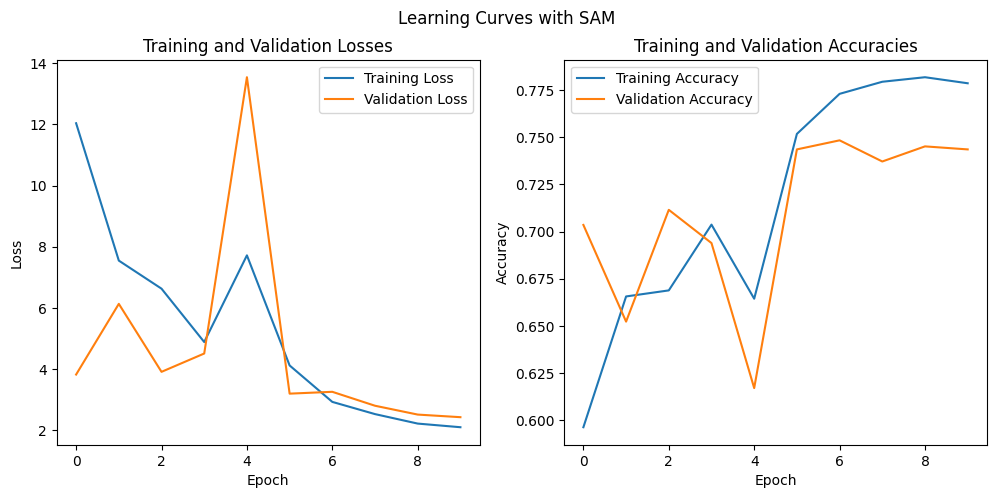

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "SAM")

## MobileNet-V3

In [ ]:
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)

base_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

transform = transforms.Compose([
        color_jitter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Fake_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Fake_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Worse results on validation!

### Adam

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(2)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.626 | Train Acc: 64.27% | Train F1: 64.26%
	 Val. Loss: 0.611 |  Val. Acc: 64.26% | Val F1: 63.60%
Epoch: 02
	Train Loss: 0.563 | Train Acc: 70.21% | Train F1: 70.21%
	 Val. Loss: 0.592 |  Val. Acc: 68.59% | Val F1: 68.51%
Epoch: 03
	Train Loss: 0.520 | Train Acc: 74.14% | Train F1: 74.12%
	 Val. Loss: 0.569 |  Val. Acc: 69.87% | Val F1: 69.84%
Epoch: 04
	Train Loss: 0.512 | Train Acc: 74.82% | Train F1: 74.82%
	 Val. Loss: 0.553 |  Val. Acc: 69.71% | Val F1: 69.71%
Epoch: 05
	Train Loss: 0.515 | Train Acc: 74.06% | Train F1: 74.04%
	 Val. Loss: 0.561 |  Val. Acc: 69.71% | Val F1: 69.67%
Epoch: 06
	Train Loss: 0.498 | Train Acc: 74.62% | Train F1: 74.61%
	 Val. Loss: 0.554 |  Val. Acc: 70.35% | Val F1: 70.34%
Epoch: 07
	Train Loss: 0.513 | Train Acc: 74.42% | Train F1: 74.41%
	 Val. Loss: 0.552 |  Val. Acc: 71.31% | Val F1: 71.31%
Epoch: 08
	Train Loss: 0.509 | Train Acc: 74.50% | Train F1: 74.49%
	 Val. Loss: 0.550 |  Val. Acc: 71.15% | Val F1: 71.15%
Epoch: 0

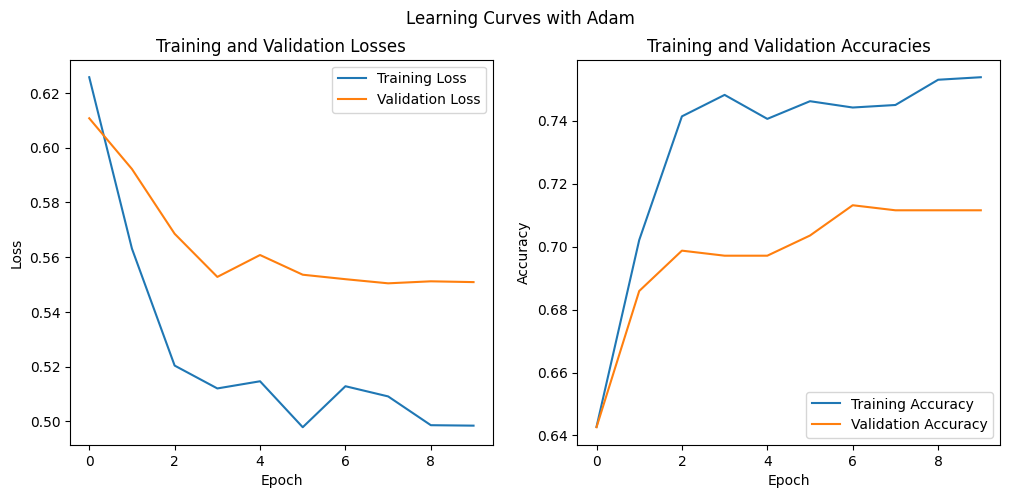

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "Adam")

## Custom CNN

In [ ]:
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)

base_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

transform = transforms.Compose([
        color_jitter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Fake_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Fake_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

We saw more difference between train and validation accuracy in here:

### Adam

In [ ]:
# Instantiate the model
model = CNNModel(2)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.517 | Train Acc: 73.06% | Train F1: 73.06%
	 Val. Loss: 0.559 |  Val. Acc: 71.63% | Val F1: 71.63%
Epoch: 02
	Train Loss: 0.498 | Train Acc: 74.30% | Train F1: 74.29%
	 Val. Loss: 0.553 |  Val. Acc: 72.12% | Val F1: 72.12%
Epoch: 03
	Train Loss: 0.511 | Train Acc: 75.54% | Train F1: 75.53%
	 Val. Loss: 0.558 |  Val. Acc: 71.63% | Val F1: 71.61%
Epoch: 04
	Train Loss: 0.491 | Train Acc: 75.58% | Train F1: 75.57%
	 Val. Loss: 0.550 |  Val. Acc: 71.47% | Val F1: 71.47%
Epoch: 05
	Train Loss: 0.501 | Train Acc: 74.82% | Train F1: 74.80%
	 Val. Loss: 0.549 |  Val. Acc: 72.28% | Val F1: 72.27%
Epoch: 06
	Train Loss: 0.481 | Train Acc: 76.82% | Train F1: 76.82%
	 Val. Loss: 0.550 |  Val. Acc: 72.28% | Val F1: 72.27%
Epoch: 07
	Train Loss: 0.481 | Train Acc: 75.66% | Train F1: 75.66%
	 Val. Loss: 0.550 |  Val. Acc: 72.44% | Val F1: 72.43%
Epoch: 08
	Train Loss: 0.483 | Train Acc: 76.18% | Train F1: 76.18%
	 Val. Loss: 0.548 |  Val. Acc: 71.79% | Val F1: 71.78%
Epoch: 0

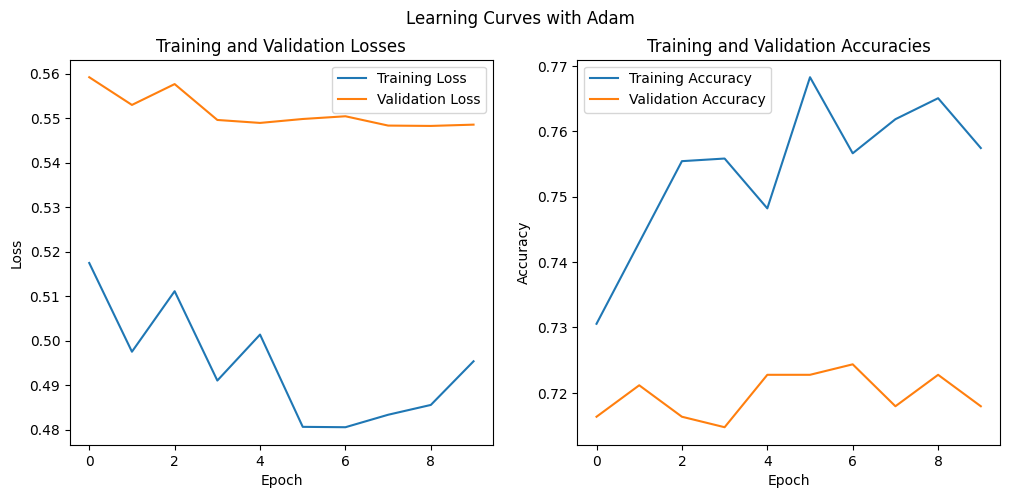

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "Adam")

# Learning Rate Schedular

If we want to compare different networks in this part based on performance at first place we have ResNet, second place MobileNet and CNN at the end. Among different schedulers, CyclicLR and StepLR had slightly better results

In [ ]:
def train_model_with_schedular(model, train_loader, val_loader, criterion, optimizer, scheduler, transform=None, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    opt_name = optimizer.__class__.__name__

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_labels_train = []
        all_predictions_train = []

        for inputs, labels  in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            if transform == 'mixup':
                mixup_inputs, mixup_labels = mixup_data(inputs, labels, num_classes=2)
                outputs = model(mixup_inputs)
                loss = criterion(outputs, mixup_labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            if opt_name == 'SAM':
                # SAM needs two steps
                # first forward-backward pass
                optimizer.first_step(zero_grad=True)

                # second forward-backward pass
                criterion(model(inputs), labels).backward()  # make sure to do a full forward pass
                optimizer.second_step(zero_grad=True)
            else:
                optimizer.step()

            running_loss += loss.item()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            all_labels_train.extend(labels.cpu().numpy())
            all_predictions_train.extend(predicted_train.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        epoch_accuracy_train = correct_train / total_train
        train_accuracies.append(epoch_accuracy_train)

        # Calculate F1 score
        f1_train = f1_score(all_labels_train, all_predictions_train, average='weighted')

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        running_loss_val = 0.0
        all_labels_val = []
        all_predictions_val = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs_val = model(inputs)
                loss_val = criterion(outputs_val, labels)
                running_loss_val += loss_val.item()

                _, predicted_val = torch.max(outputs_val.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

                all_labels_val.extend(labels.cpu().numpy())
                all_predictions_val.extend(predicted_val.cpu().numpy())

        epoch_loss_val = running_loss_val / len(val_loader)
        val_losses.append(epoch_loss_val)
        epoch_accuracy_val = correct_val / total_val
        val_accuracies.append(epoch_accuracy_val)

        # Calculate F1 score
        f1_val = f1_score(all_labels_val, all_predictions_val, average='weighted')

        # Update learning rate
        scheduler.step()

        # Print and store results for analysis
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {epoch_loss:.3f} | Train Acc: {epoch_accuracy_train*100:.2f}% | Train F1: {f1_train*100:.2f}%')
        print(f'\t Val. Loss: {epoch_loss_val:.3f} |  Val. Acc: {epoch_accuracy_val*100:.2f}% | Val F1: {f1_val*100:.2f}%')


    # Save the model weights after training
    torch.save(model.state_dict(), f'{model_save_path}/{model._get_name()}_{scheduler.__class__.__name__}.pth')

    return train_losses, val_losses, train_accuracies, val_accuracies

ColorJitter and Adam:

In [ ]:
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)

base_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

transform = transforms.Compose([
        color_jitter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Fake_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Fake_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## ResNet-152

### Expotential LR

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

Epoch: 01
	Train Loss: 0.687 | Train Acc: 57.98% | Train F1: 57.98%
	 Val. Loss: 0.616 |  Val. Acc: 67.15% | Val F1: 65.41%
Epoch: 02
	Train Loss: 0.591 | Train Acc: 68.93% | Train F1: 68.91%
	 Val. Loss: 0.556 |  Val. Acc: 70.35% | Val F1: 70.34%
Epoch: 03
	Train Loss: 0.558 | Train Acc: 71.33% | Train F1: 71.32%
	 Val. Loss: 0.560 |  Val. Acc: 69.55% | Val F1: 68.80%
Epoch: 04
	Train Loss: 0.548 | Train Acc: 72.73% | Train F1: 72.72%
	 Val. Loss: 0.537 |  Val. Acc: 72.44% | Val F1: 72.35%
Epoch: 05
	Train Loss: 0.526 | Train Acc: 73.30% | Train F1: 73.29%
	 Val. Loss: 0.533 |  Val. Acc: 73.08% | Val F1: 72.95%
Epoch: 06
	Train Loss: 0.522 | Train Acc: 74.18% | Train F1: 74.17%
	 Val. Loss: 0.521 |  Val. Acc: 73.40% | Val F1: 73.36%
Epoch: 07
	Train Loss: 0.511 | Train Acc: 74.94% | Train F1: 74.93%
	 Val. Loss: 0.516 |  Val. Acc: 73.08% | Val F1: 73.08%
Epoch: 08
	Train Loss: 0.528 | Train Acc: 73.62% | Train F1: 73.60%
	 Val. Loss: 0.521 |  Val. Acc: 72.92% | Val F1: 72.84%
Epoch: 0

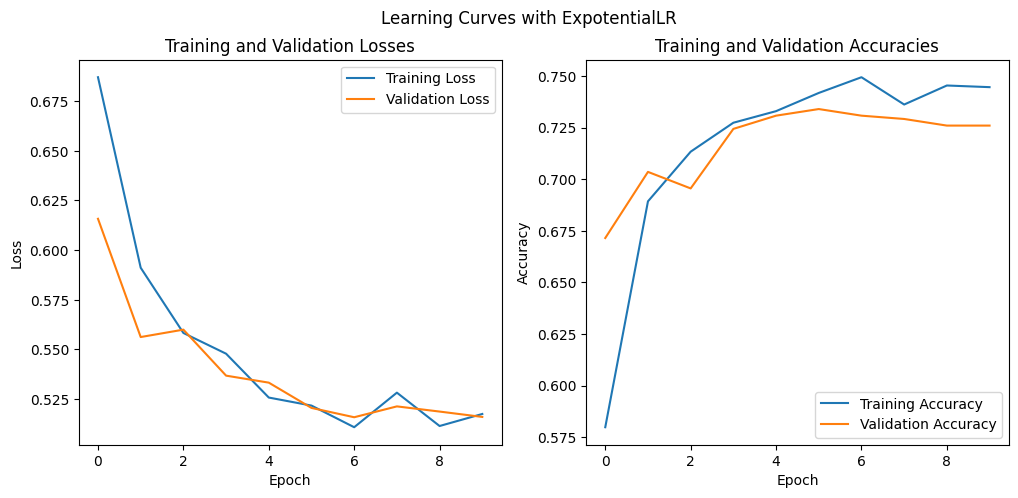

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "ExpotentialLR")

### Linear LR

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=10)

Epoch: 01
	Train Loss: 0.679 | Train Acc: 58.74% | Train F1: 58.74%
	 Val. Loss: 0.578 |  Val. Acc: 70.03% | Val F1: 70.02%
Epoch: 02
	Train Loss: 0.583 | Train Acc: 68.81% | Train F1: 68.77%
	 Val. Loss: 0.557 |  Val. Acc: 71.47% | Val F1: 71.20%
Epoch: 03
	Train Loss: 0.571 | Train Acc: 70.09% | Train F1: 70.08%
	 Val. Loss: 0.539 |  Val. Acc: 72.12% | Val F1: 72.01%
Epoch: 04
	Train Loss: 0.541 | Train Acc: 72.05% | Train F1: 72.05%
	 Val. Loss: 0.526 |  Val. Acc: 72.92% | Val F1: 72.92%
Epoch: 05
	Train Loss: 0.534 | Train Acc: 73.66% | Train F1: 73.65%
	 Val. Loss: 0.555 |  Val. Acc: 70.99% | Val F1: 70.20%
Epoch: 06
	Train Loss: 0.544 | Train Acc: 72.77% | Train F1: 72.76%
	 Val. Loss: 0.526 |  Val. Acc: 71.79% | Val F1: 71.61%
Epoch: 07
	Train Loss: 0.514 | Train Acc: 74.06% | Train F1: 74.05%
	 Val. Loss: 0.526 |  Val. Acc: 72.76% | Val F1: 72.71%
Epoch: 08
	Train Loss: 0.512 | Train Acc: 75.30% | Train F1: 75.30%
	 Val. Loss: 0.521 |  Val. Acc: 73.88% | Val F1: 73.88%
Epoch: 0

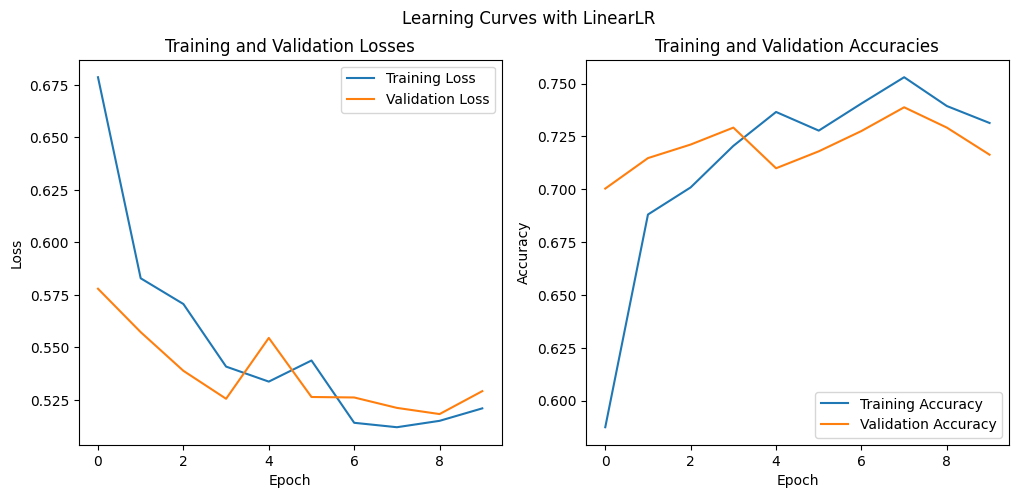

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "LinearLR")

### Cyclic LR

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(2)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=2000, cycle_momentum=False)

Epoch: 01
	Train Loss: 0.681 | Train Acc: 58.78% | Train F1: 58.78%
	 Val. Loss: 0.576 |  Val. Acc: 69.23% | Val F1: 69.21%
Epoch: 02
	Train Loss: 0.593 | Train Acc: 67.60% | Train F1: 67.59%
	 Val. Loss: 0.555 |  Val. Acc: 71.15% | Val F1: 70.99%
Epoch: 03
	Train Loss: 0.566 | Train Acc: 70.81% | Train F1: 70.79%
	 Val. Loss: 0.555 |  Val. Acc: 70.03% | Val F1: 69.65%
Epoch: 04
	Train Loss: 0.545 | Train Acc: 71.41% | Train F1: 71.41%
	 Val. Loss: 0.597 |  Val. Acc: 68.27% | Val F1: 66.46%
Epoch: 05
	Train Loss: 0.549 | Train Acc: 71.49% | Train F1: 71.49%
	 Val. Loss: 0.549 |  Val. Acc: 72.44% | Val F1: 71.89%
Epoch: 06
	Train Loss: 0.535 | Train Acc: 73.54% | Train F1: 73.53%
	 Val. Loss: 0.564 |  Val. Acc: 70.19% | Val F1: 69.03%
Epoch: 07
	Train Loss: 0.529 | Train Acc: 74.02% | Train F1: 74.01%
	 Val. Loss: 0.522 |  Val. Acc: 72.76% | Val F1: 72.75%
Epoch: 08
	Train Loss: 0.523 | Train Acc: 74.26% | Train F1: 74.26%
	 Val. Loss: 0.524 |  Val. Acc: 73.56% | Val F1: 73.54%
Epoch: 0

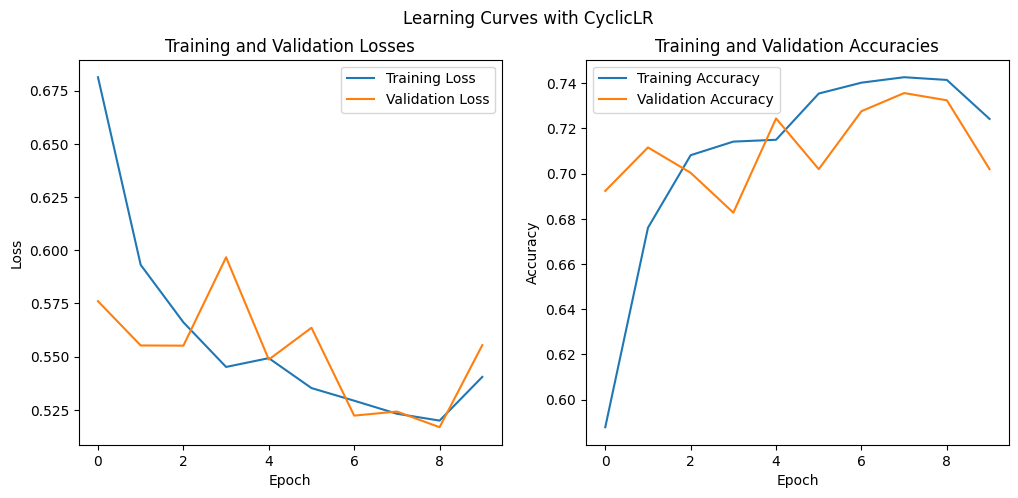

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "CyclicLR")

### Step LR

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.659 | Train Acc: 60.55% | Train F1: 60.90%
	 Val. Loss: 0.581 |  Val. Acc: 68.27% | Val F1: 67.94%
Epoch: 02
	Train Loss: 0.591 | Train Acc: 68.40% | Train F1: 68.39%
	 Val. Loss: 0.581 |  Val. Acc: 67.31% | Val F1: 65.55%
Epoch: 03
	Train Loss: 0.570 | Train Acc: 70.25% | Train F1: 70.24%
	 Val. Loss: 0.548 |  Val. Acc: 71.15% | Val F1: 70.82%
Epoch: 04
	Train Loss: 0.558 | Train Acc: 71.61% | Train F1: 71.60%
	 Val. Loss: 0.535 |  Val. Acc: 71.79% | Val F1: 71.77%
Epoch: 05
	Train Loss: 0.530 | Train Acc: 72.98% | Train F1: 72.97%
	 Val. Loss: 0.528 |  Val. Acc: 72.60% | Val F1: 72.59%
Epoch: 06
	Train Loss: 0.508 | Train Acc: 74.62% | Train F1: 74.60%
	 Val. Loss: 0.524 |  Val. Acc: 73.40% | Val F1: 73.40%
Epoch: 07
	Train Loss: 0.518 | Train Acc: 74.42% | Train F1: 74.42%
	 Val. Loss: 0.525 |  Val. Acc: 72.60% | Val F1: 72.52%
Epoch: 08
	Train Loss: 0.507 | Train Acc: 75.22% | Train F1: 75.22%
	 Val. Loss: 0.522 |  Val. Acc: 73.88% | Val F1: 73.88%
Epoch: 0

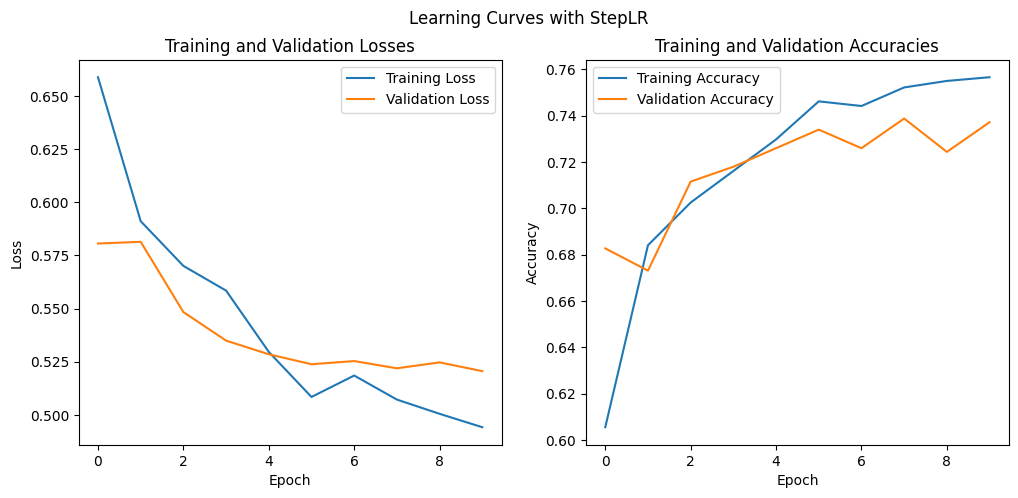

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "StepLR")

## MobileNet-V3

### Linear LR

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(2)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=10)

Epoch: 01
	Train Loss: 0.626 | Train Acc: 64.76% | Train F1: 64.76%
	 Val. Loss: 0.636 |  Val. Acc: 66.19% | Val F1: 64.98%
Epoch: 02
	Train Loss: 0.569 | Train Acc: 70.49% | Train F1: 70.45%
	 Val. Loss: 0.594 |  Val. Acc: 69.55% | Val F1: 69.41%
Epoch: 03
	Train Loss: 0.537 | Train Acc: 72.45% | Train F1: 72.44%
	 Val. Loss: 0.577 |  Val. Acc: 69.87% | Val F1: 69.86%
Epoch: 04
	Train Loss: 0.518 | Train Acc: 74.22% | Train F1: 74.22%
	 Val. Loss: 0.574 |  Val. Acc: 69.39% | Val F1: 69.37%
Epoch: 05
	Train Loss: 0.518 | Train Acc: 73.66% | Train F1: 73.64%
	 Val. Loss: 0.560 |  Val. Acc: 70.51% | Val F1: 70.51%
Epoch: 06
	Train Loss: 0.500 | Train Acc: 75.42% | Train F1: 75.42%
	 Val. Loss: 0.558 |  Val. Acc: 71.31% | Val F1: 71.31%
Epoch: 07
	Train Loss: 0.504 | Train Acc: 75.22% | Train F1: 75.20%
	 Val. Loss: 0.552 |  Val. Acc: 71.63% | Val F1: 71.62%
Epoch: 08
	Train Loss: 0.500 | Train Acc: 74.66% | Train F1: 74.66%
	 Val. Loss: 0.551 |  Val. Acc: 71.47% | Val F1: 71.47%
Epoch: 0

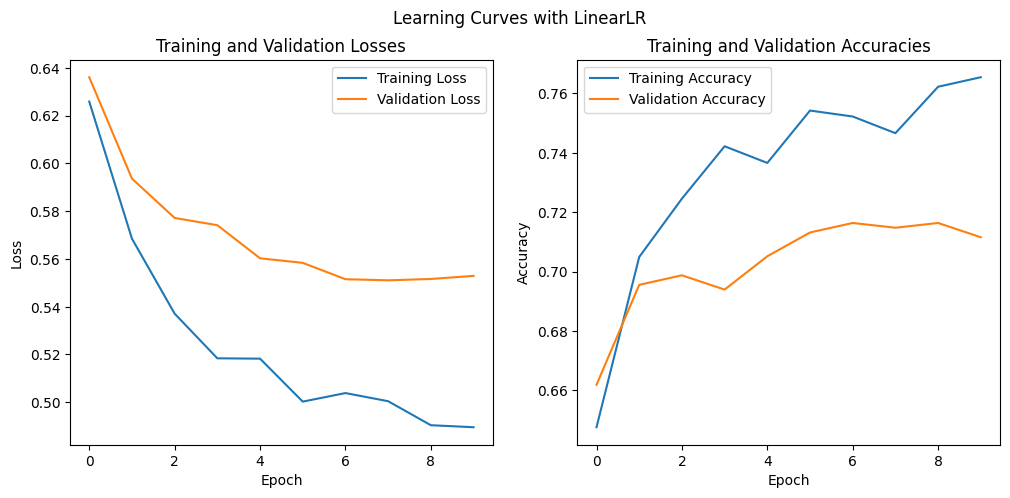

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "LinearLR")

## Custom CNN

### Linear LR

In [ ]:
# Instantiate the model
model = CNNModel(2)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=10)

Epoch: 01
	Train Loss: 0.712 | Train Acc: 53.41% | Train F1: 53.40%
	 Val. Loss: 0.723 |  Val. Acc: 50.96% | Val F1: 50.93%
Epoch: 02
	Train Loss: 0.697 | Train Acc: 53.41% | Train F1: 53.25%
	 Val. Loss: 0.703 |  Val. Acc: 52.72% | Val F1: 46.31%
Epoch: 03
	Train Loss: 0.679 | Train Acc: 57.30% | Train F1: 57.29%
	 Val. Loss: 0.698 |  Val. Acc: 54.49% | Val F1: 50.29%
Epoch: 04
	Train Loss: 0.677 | Train Acc: 56.90% | Train F1: 56.88%
	 Val. Loss: 0.695 |  Val. Acc: 55.13% | Val F1: 51.21%
Epoch: 05
	Train Loss: 0.667 | Train Acc: 59.30% | Train F1: 59.30%
	 Val. Loss: 0.646 |  Val. Acc: 63.14% | Val F1: 61.09%
Epoch: 06
	Train Loss: 0.670 | Train Acc: 59.14% | Train F1: 59.14%
	 Val. Loss: 0.648 |  Val. Acc: 62.98% | Val F1: 61.51%
Epoch: 07
	Train Loss: 0.658 | Train Acc: 59.66% | Train F1: 59.64%
	 Val. Loss: 0.639 |  Val. Acc: 65.22% | Val F1: 65.10%
Epoch: 08
	Train Loss: 0.652 | Train Acc: 61.23% | Train F1: 61.21%
	 Val. Loss: 0.663 |  Val. Acc: 59.62% | Val F1: 55.92%
Epoch: 0

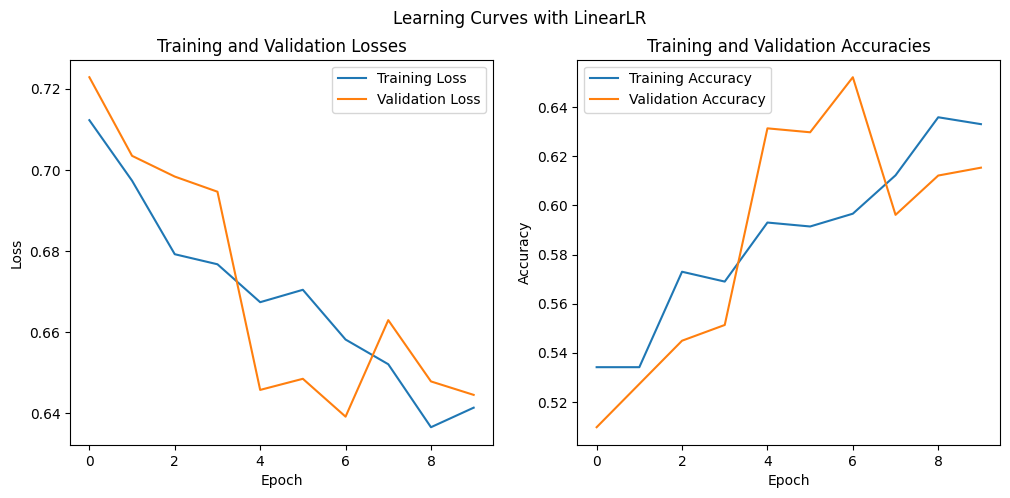

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "LinearLR")